In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import fit_quenching_linear_unitless, calc_quenched_flour, mark_non_quenchers
from quenching import well_mean_with_error_propagation

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/RTDP_isolate_supes/RTDP_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/RTDP_isolate_supes/RTDP_long_df_post.csv', index_col=0)

# No need to drop the first measurement here. At this point had altered the protocol to 
# manually mix before measuring in the plate reader.

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, rtdp_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "rtdp_fluor", "RTDP")

# In this case data comes from a single date, so there is only one blank (mean+/-std) and reference value.
blank_val = blank_vals.iloc[0]
rtdp_alone_fluor = rtdp_alone_fluors.iloc[0]

long_df_pre.to_csv("../data/RTDP_isolate_supes/RTDP_long_df_pre_processed.csv")
long_df_post.to_csv("../data/RTDP_isolate_supes/RTDP_long_df_post_processed.csv")

print("blank", blank_val)
print("RTDP in buffer", rtdp_alone_fluor)
cv = rtdp_alone_fluor.std_dev/rtdp_alone_fluor.nominal_value
print("CV of RTDP in buffer {0:.2f}%".format(100*cv))

blank 1.07+/-0.25
RTDP in buffer (4.03+/-0.16)e+03
CV of RTDP in buffer 4.01%


In [3]:
# Peek at the data
long_df_post.head()

,time_s,well,rtdp_fluor,concentration,fold_dilution,media,name,replicate,plate,date,blanked_rtdp_fluor,expected_blanked_rtdp_fluor,estimated_true_rtdp_fluor,F0_F_ratio,F_F0_ratio,u_blanked_rtdp_fluor,u_expected_blanked_rtdp_fluor,u_estimated_true_rtdp_fluor,u_F0_F_ratio,u_F_F0_ratio
0,0.000,A1,2055,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,2053.932292,4081.478557,2007.146443,2.010164,0.497472,0.251902,161.848237,0.024963,0.080636,0.019956
1,74.683,A1,2055,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,2053.932292,4082.379458,2006.245542,2.011066,0.497249,0.251902,161.848237,0.024963,0.080672,0.019947
2,149.369,A1,2031,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,2029.932292,4082.379458,1982.245542,2.035415,0.491300,0.251902,161.848237,0.024963,0.081649,0.019708
3,224.057,A1,2037,0.900901,1,MM gluc+AA,PA14 WT,1,1,5/27/22,2035.932292,4082.379458,1988.245542,2.029273,0.492787,0.251902,161.848237,0.024963,0.081402,0.019768
4,0.000,A2,2536,0.450450,2,MM gluc+AA,PA14 WT,1,1,5/27/22,2534.932292,4065.262340,2504.362660,1.611066,0.620707,0.251902,161.848237,0.024963,0.064626,0.024899


In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "rtdp_fluor", rtdp_alone_fluor)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "rtdp_fluor", rtdp_alone_fluor)
means_pre_by_rep.to_csv("../data/RTDP_isolate_supes/mean_rtdp_fluor_pre.csv")
means_post_by_rep.to_csv("../data/RTDP_isolate_supes/mean_rtdp_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. 
# See Gehlen J. Photochem. Photobio. 2020 for summary and Szabo J Phys Chem 1989 for derivations. 

name_order = sorted(
    set(long_df_post.name.unique()).difference('BLANK,RTDP'.split(',')))
print(name_order)
quencher_fit_df = fit_quenching_linear_unitless(means_post_by_rep.reset_index(), name_order)

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enought to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (RTDP here) in buffer. 
print("Minimum effect size (CV of RTDP alone): {0:.2g}".format(cv))
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_effect_size=cv)

# Save the fits
quencher_fit_df.to_csv("../data/RTDP_isolate_supes/fits.csv")
quencher_fit_df

['AGG', 'BG', 'CG', 'CS', 'EC WT', 'MM4', 'PA14 WT', 'PO', 'PS']
Fitting AGG
	F0/F ~ [AGG] with R = 0.638
Fitting BG
	F0/F ~ [BG] with R = 0.684
Fitting CG
	F0/F ~ [CG] with R = 0.915
Fitting CS
	F0/F ~ [CS] with R = 0.614
Fitting EC WT
	F0/F ~ [EC WT] with R = 0.943
Fitting MM4
	F0/F ~ [MM4] with R = 0.664
Fitting PA14 WT
	F0/F ~ [PA14 WT] with R = 0.980
Fitting PO
	F0/F ~ [PO] with R = 0.864
Fitting PS
	F0/F ~ [PS] with R = 0.942
Minimum effect size (CV of RTDP alone): 0.04


,name,K_SV,K_SV err,R,quencher
0,AGG,0.680241,0.057279,0.638263,True
1,BG,0.487551,0.052865,0.684224,True
2,CG,0.461831,0.054092,0.915200,True
3,CS,0.638354,0.055084,0.613528,True
4,EC WT,0.294595,0.047340,0.943386,True
5,MM4,0.164062,0.043345,0.664272,True
6,PA14 WT,1.290962,0.072917,0.980136,True
7,PO,0.699549,0.056520,0.864442,True
8,PS,0.712817,0.058399,0.941870,True


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

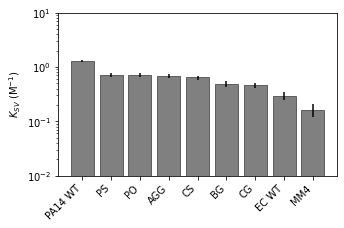

In [6]:
# Take a peek at the linear KSV fits. 
# Index fits by name for easier lookup
rtdp_fits = quencher_fit_df.set_index('name').sort_values('K_SV', ascending=False)

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, so it gives much larger errors in the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(rtdp_fits.index.size)
ys = rtdp_fits['K_SV']
yerr = rtdp_fits['K_SV err']

plt.figure(figsize=(5,3))
plt.yscale('log')
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(rtdp_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 3, 'NQ', ha='center', fontsize=7)
        
plt.ylim(1e-2, 10)
plt.ylabel('$K_{SV}$ (M$^{-1}$)')
plt.xticks(xs, rtdp_fits.index, rotation=45, ha='right')
plt.show()

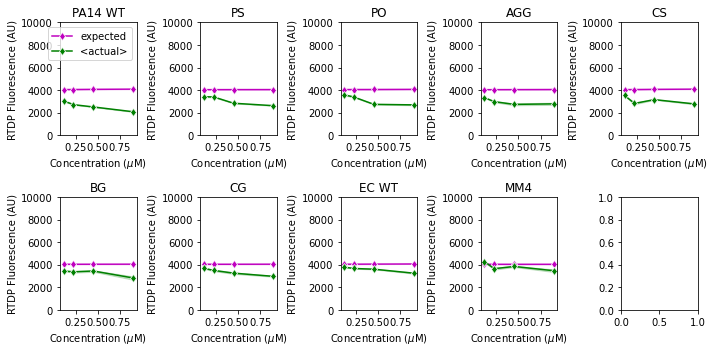

In [7]:
fig, axs = plt.subplots(figsize=(10,5), ncols=5, nrows=2)
flat_axs = axs.flatten()
name_order = rtdp_fits.index.values
#name_order = ['EC WT', 'PA14 WT', 'PA14 dphz', 'PA14 dphz dside', 'PA14 dside', 'BG WT', 'BG dtox']

for i, media in enumerate(long_df_post.media.unique()):
    for j, qname in enumerate(name_order):
        my_ax = flat_axs[8*i + j]
        plt.sca(my_ax)
        
        mask = np.logical_and(
            long_df_post.name == qname, long_df_post.media == media)
        qdf_post = long_df_post[mask]

        sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_rtdp_fluor', 
                     color='m', marker='d', markersize=6, label='expected')

        sns.lineplot(data=qdf_post, x='concentration', y='blanked_rtdp_fluor', 
                     color='g', marker='d', markersize=6, 
                     label='<actual>')

        plt.title(qname)
        plt.ylim(0, 10000)
        plt.xlabel('Concentration ($\mu$M)')
        plt.ylabel('RTDP Fluorescence (AU)')

        if j > 0:
            plt.legend().set_visible(False)
    
plt.tight_layout()
plt.show()

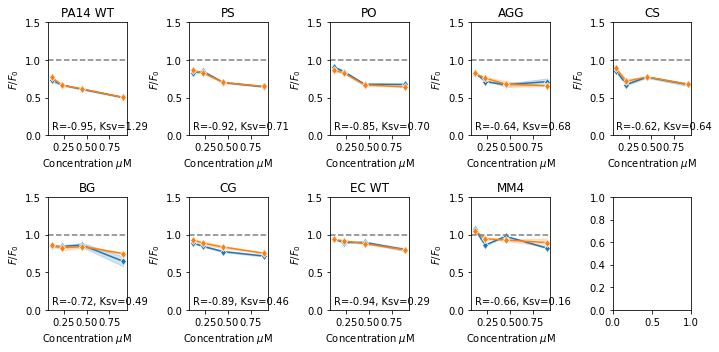

In [8]:
fig, axs = plt.subplots(figsize=(10,5), ncols=5, nrows=2)
flat_axs = axs.flatten()

for i, media in enumerate(long_df_post.media.unique()):
    for j, qname in enumerate(name_order):
        my_ax = flat_axs[8*i + j]
        plt.sca(my_ax)
        
        mask = np.logical_and(
            long_df_post.name == qname, long_df_post.media == media)
        qdf_post = long_df_post[mask]

        sns.lineplot(data=qdf_post, x='concentration', y='F_F0_ratio', 
                     color='m', marker='d', markersize=6,
                     hue=qdf_post[['date', 'replicate']].apply(tuple, axis=1),
                     legend=False)

        corr = qdf_post.corr().loc['concentration', 'F_F0_ratio']
        slope = rtdp_fits.loc[qname]['K_SV']
        plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.2f}'.format(corr, slope),
                 transform=my_ax.transAxes)
        plt.axhline(1, ls='--', color='grey')

        plt.title(qname)
        plt.ylim(0, 1.5)
        plt.xlabel('Concentration $\mu$M')
        plt.ylabel('$F / F_0$')
    
plt.tight_layout()
plt.show()